In [1]:
library(INLA)
library(invgamma)
library("MASS")
library("fdrtool")

Loading required package: Matrix

Loading required package: foreach

Loading required package: parallel

Loading required package: sp

This is INLA_23.04.24 built 2023-04-24 19:15:35 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - To enable PARDISO sparse library; see inla.pardiso()



In [82]:
n = 100
x= (1:n) / n

length = 0.5
var = 1

# distance matrix
XtX <- tcrossprod(x)
XX <- matrix(1, n) %*% diag(XtX)
D <- XX - 2 * XtX + t(XX) # distance matrix

# complete kernel
K = var * exp(-0.5 * (D/length ** 2 ))
K = K + diag(2e-5, n, n)

precision = Matrix::solve((K))

In [99]:
y_obs = mvrnorm(1, rep(0, n), K)

#obs_idx = c(1, 6,7,8)
obs_idx = c(8, 9, 10, 11, 16, 17, 20, 24, 28, 32, 34, 35,37,40, 41, 45,55, 57,59, 61, 72, 77, 81, 84)
observations = rep(NA, n)

gt_plot_colours = rep(1, n)

for (i in 1:length(obs_idx)){
    observations[obs_idx[i]] = y_obs[obs_idx[i]]
    gt_plot_colours[obs_idx[i]] = 2
}
na_points = which(is.na(observations))

In [103]:
plot_results <- function(ground_truth, results){
  inference_means_plus_true = rep(NA, n)
  colours = rep(NA, n)
  for (i in 1:length(obs_idx)){
    inference_means_plus_true[obs_idx[i]] = observations[obs_idx[i]] 
    colours[obs_idx[i]] = 1
  }
  for (i in 1:length(na_points)){
    inference_means_plus_true[na_points[i]] = results$summary.fitted.values[i, c("mode")]
    colours[na_points[i]] = 2
  }

  low_quantile = as.vector(results$summary.fitted.values[c("0.025quant")])$`0.025quant`
  high_quantile = as.vector(results$summary.fitted.values[c("0.975quant")])$`0.975quant`

  plot(x, inference_means_plus_true, col=colours, pch=20, ylim=c(-1,1))
  lines(x,low_quantile, col=3)
  lines(x, y_obs, col=4)
  lines(x, high_quantile, col=3)
  legend("topright", legend = c("Observations", "Predicted", "95% CI", "Ground truth"), col = 1:4, pch = 20, bty = "n")


}

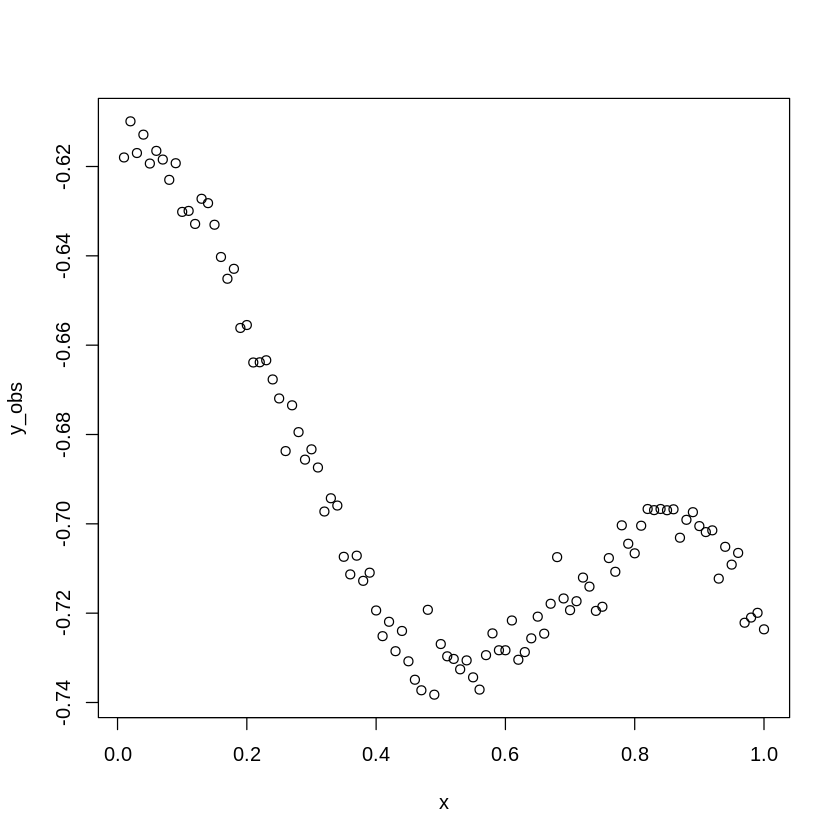

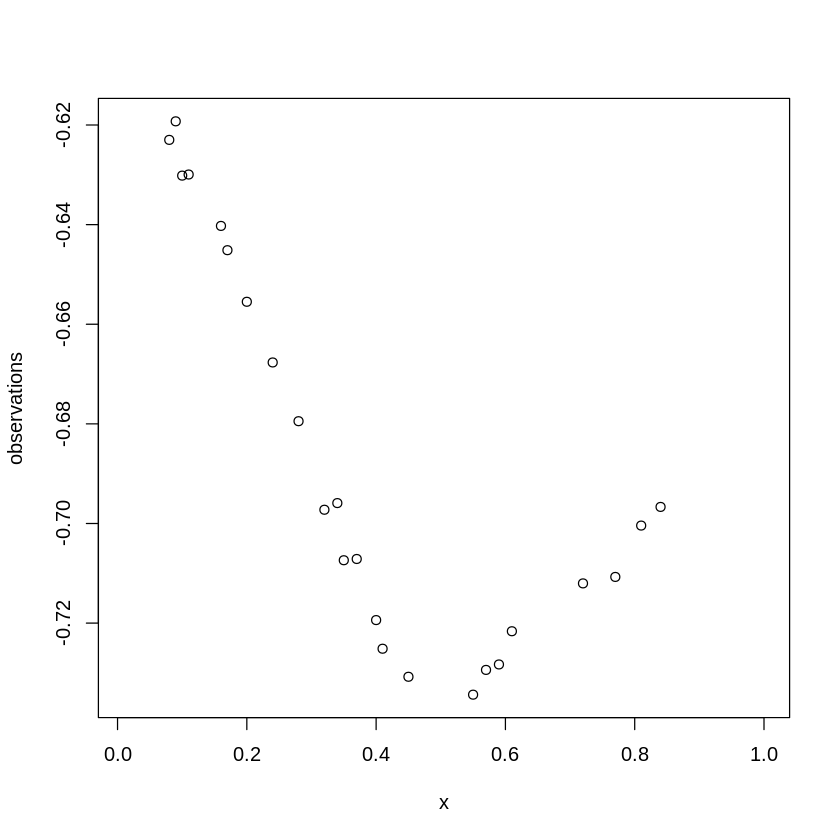

In [100]:
plot(x, y_obs)
plot(x,observations)

In [101]:
data <- list(id = 1:n,
            y = observations)

  [1] -0.009412333  0.055066873  0.113073890  0.164900197  0.210930824
  [6]  0.251545215  0.287115725 -0.622985796 -0.619262181 -0.630161139
 [11] -0.629938069 -0.622952123 -0.619227692 -0.630125453 -0.629901715
 [16] -0.640258755 -0.645129622  0.401682180  0.414252871 -0.655487869
 [21]  0.424086724  0.431459730 -0.640220224 -0.667670328 -0.645090802
 [26]  0.441344061  0.441326026 -0.679462898 -0.655448674  0.437533697
 [31]  0.434109387 -0.697238583  0.429874433 -0.695902574 -0.707377030
 [36] -0.667631235 -0.707124263  0.419509570  0.413613500 -0.719390702
 [41] -0.725140639  0.407375648 -0.679424245  0.394203229 -0.730772389
 [46]  0.387404990  0.380539174 -0.697200267  0.366771329 -0.695864797
 [51] -0.707339085  0.346452643 -0.707086803  0.333314308 -0.734365052
 [56]  0.326886586 -0.729394694 -0.719353493 -0.728299328 -0.725103448
 [61] -0.721631841  0.308161867  0.302093958  0.296104467 -0.730735859
 [66]  0.284339903  0.278555780  0.272832588  0.267168443  0.261562855
 [71] 

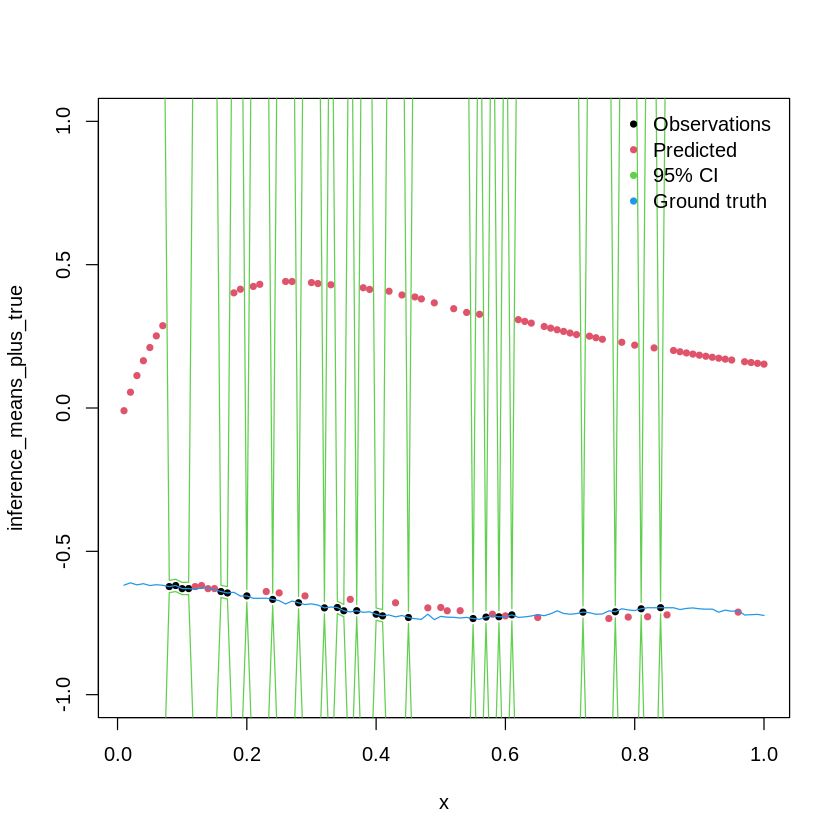

In [102]:
formula1 <- y ~ 0 + f(id, model = "z", Z = diag(1, n), Cmatrix=K)

fit1 <- INLA::inla(formula1,
                family = "gaussian",
                data = data,
                control.predictor = list(compute = TRUE, link = 1),

                verbose = TRUE,
                inla.mode = "experimental")

plot_results(y_obs, fit1)

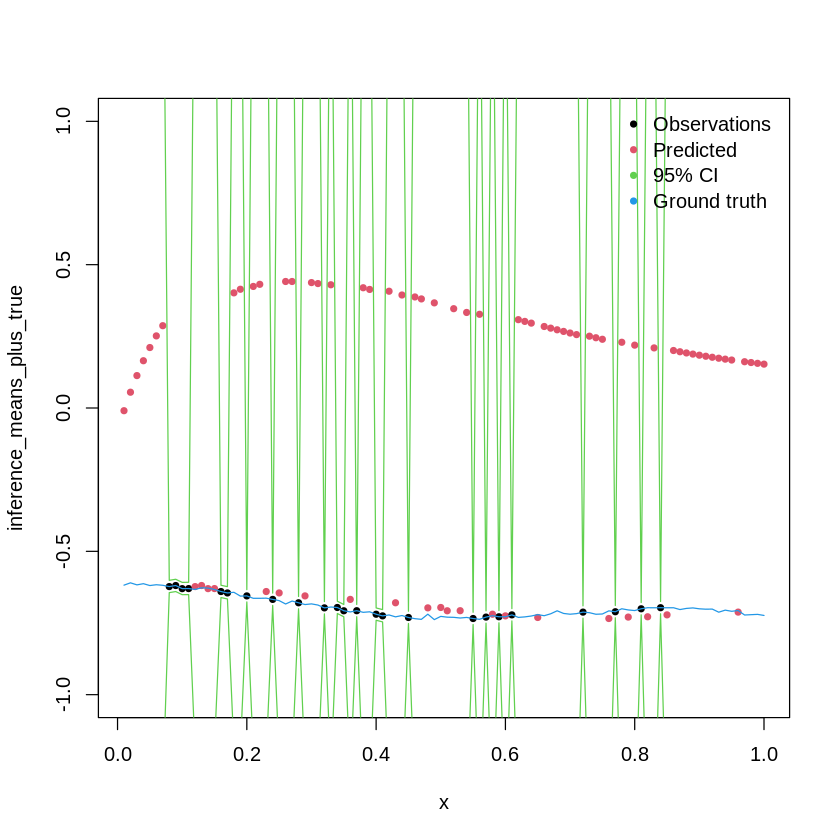

In [107]:
theta_prior <- list(prec = list(prior = "logtnormal", param = c(0, 0.8),
                            initial = 0, fixed = FALSE))

formula2 <- y ~ 0 + f(id, model = "generic0", Cmatrix = K, hyper=theta_prior)

fit2 <- INLA::inla(formula2,
                family = "gaussian",
                data = data,
                control.predictor = list(compute = TRUE, link = 1),

                verbose = TRUE,
                inla.mode = "experimental")

plot_results(y_obs, fit2)